In [ ]:
#%pip install wbgapi
import wbgapi as wb
import pandas as pd
import requests
import pandas as pd
from io import StringIO
from datetime import datetime
import math

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # o 'Arial', 'Times New Roman', etc.
import seaborn as sns
import missingno as msno       # Para visualización de valores nulos
import scipy.stats as stats    # Para pruebas estadísticas
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency
import ruptures as rpt


# 📊 Extracción de datos del Banco Mundial usando el API

En este paso se realiza una selección de **15 variables socioeconómicas**, agrupadas por temática:

## Ciencia y tecnología

- `IP.JRN.ARTC.SC`: Artículos en publicaciones científicas y técnicas  
- `SP.POP.SCIE.RD.P6`: Investigadores dedicados a investigación y desarrollo (por cada millón de personas)  
- `GB.XPD.RSDV.GD.ZS`: Gasto en investigación y desarrollo (% del PIB)  
- `SP.POP.TECH.RD.P6`: Técnicos de investigación y desarrollo (por cada millón de personas)  


## Economía y crecimiento

- `NY.GDP.PCAP.CD`: PIB per cápita (US$ a precios actuales)  

## Educación

- `SE.XPD.TOTL.GD.ZS`: Gasto público en educación, total (% del PIB)  
- `SE.PRM.ENRR`: Inscripción escolar, nivel primario (% bruto)  
- `SE.SEC.ENRR`: Inscripción escolar, nivel secundario (% bruto)  
- `SE.TER.ENRR`: Inscripción escolar, nivel terciario (% bruto)  
- `SE.XPD.TOTL.GB.ZS`: Gasto público en educación, total (% del gasto del gobierno)  

## Cambio climático

- `ER.PTD.TOTL.ZS`: Áreas protegidas terrestres y marinas (% del total de la superficie territorial)  
- `AG.LND.FRST.K2`: Área selvática (kilómetros cuadrados)  


## Ambiente

- `AG.SRF.TOTL.K2`: Superficie (kilómetros cuadrados)  


## Sector público

- `GE.EST`: Government Effectiveness (Estimate)  


## Infraestructura

- `IT.NET.USER.ZS`: Individuos que utilizan Internet (% de la población)


In [2]:
wb.source.info()
wb.economy.info(db=75)


# Lista de variables seleccionadas del Banco Mundial
SEvar = ['GB.XPD.RSDV.GD.ZS','IP.JRN.ARTC.SC', 'SP.POP.SCIE.RD.P6', 'SP.POP.TECH.RD.P6', 'NY.GDP.PCAP.CD', 'SE.XPD.TOTL.GD.ZS', 'SE.XPD.TOTL.GB.ZS', 'SE.PRM.ENRR', 'SE.SEC.ENRR','SE.TER.ENRR', 'ER.PTD.TOTL.ZS', 'AG.LND.FRST.K2', 'AG.SRF.TOTL.K2', 'GE.EST' , 'IT.NET.USER.ZS']


# Países participantes en GBIF
GBIF_countries = ['AND', 'AGO', 'ARG', 'ARM', 'AUS', 'BEL', 'BEN', 'BRA', 'BDI', 'KHM', 'CMR', 'CAN', 'CAF',
 'CHL', 'COL', 'CRI', 'HRV', 'DNK', 'ECU', 'EST', 'FIN', 'FRA', 'GEO', 'DEU', 'GTM', 'GIN',
 'ISL', 'IRL', 'LBR', 'LUX', 'MDG', 'MWI', 'MRT', 'MEX', 'MNG', 'NAM', 'NLD', 'NZL', 'NOR',
 'PAN', 'PER', 'POL', 'PRT', 'SLE', 'SVK', 'SVN', 'ZAF', 'SSD', 'ESP', 'SUR', 'SWE', 'CHE',
 'TJK', 'TGO', 'TON', 'GBR', 'USA', 'URY', 'UZB', 'ZWE']

#Carga de datos con el API del Banco Mundial para los países seleccionados. 
#SE_Col_data= wb.data.DataFrame(SEvar, 'COL', time=range(2000, 2025), labels=True).reset_index()
SEdata= wb.data.DataFrame(SEvar, GBIF_countries, time=range(2000, 2025), labels=True).reset_index()

SEdata.head(5)


# Pivotear y organizar la tabla en un formato legible para el análisis.

# Cargar los datos
SEdata = SEdata.drop(columns=['Series'])

# Aplicar la función Melt para convertir los años de columnas a filas
SEdata_long = SEdata.melt(
    id_vars=["economy", "series", "Country"],
    var_name="Year",
    value_name="Value"
)

# Limpiar el campo Year: eliminar 'YR' y convertir a datetime
SEdata_long["Year"] = SEdata_long["Year"].str.replace("YR", "", regex=False)
SEdata_long["Year"] = pd.to_datetime(SEdata_long["Year"], format="%Y")
SEdata_long["Year"] = SEdata_long["Year"].dt.year  # Extrae solo el año como número

#Pivotear usando los valores de 'Series' como nombres de columna
SEdata_pivot = SEdata_long.pivot_table(
    index=["economy", "Country", "Year"],
    columns="series",
    values="Value",
    aggfunc="first"  # por si hay duplicados
).reset_index()

#  limpiar nombre de columnas si queda jerarquía
SEdata_pivot.columns.name = None



#Countries metadata


# URL de la API para obtener información de países
url = "https://api.worldbank.org/v2/country?format=json&per_page=300"

# Realizar la solicitud GET
response = requests.get(url)
data = response.json()

# Extraer los datos de los países
countries = data[1]  # La segunda parte del JSON contiene la lista de países

# Crear un DataFrame con la información relevante
countries_meta = pd.DataFrame([{
    "id": country["id"],
    "iso2Code": country["iso2Code"],
    "region": country["region"]["value"],
    "incomeLevel": country["incomeLevel"]["value"],
    #"lendingType": country["lendingType"]["value"], # No se incluye por no ser relevante para este análisis.
   
} for country in countries])

# Mostrar las primeras filas del DataFrame
print(countries_meta.head())



BM_Data = pd.merge(SEdata_pivot, countries_meta, left_on="economy", right_on="id", how="left")
##### Transformaciones

BM_Data  = BM_Data.rename(columns={'Year': 'year'})
BM_Data  = BM_Data.rename(columns={'Country': 'country'})
BM_Data  = BM_Data.rename(columns={'iso2Code': 'countryCode'})
dropcolumns = ['economy','id']
BM_Data = BM_Data.drop(dropcolumns, axis=1)






    id iso2Code                                             region  \
0  ABW       AW                         Latin America & Caribbean    
1  AFE       ZH                                         Aggregates   
2  AFG       AF  Middle East, North Africa, Afghanistan & Pakistan   
3  AFR       A9                                         Aggregates   
4  AFW       ZI                                         Aggregates   

   incomeLevel  
0  High income  
1   Aggregates  
2   Low income  
3   Aggregates  
4   Aggregates  


# Extracción, limpieza y unión de datos de GBIF

Este segmento del script descarga, filtra y une automáticamente datos de GBIF, centrados en ocurrencias y especies reportadas en el país y por país publicador.
Finalmente une los cuatro DataFrames usando una unión externa (outer join) por year y countryCode para obtener como resultado una tabla integrada con los conteos por país y año, tanto desde el punto de vista del país donde ocurre la observación como del país que publica.

In [3]:


############################################
# Descargar los datos y generar subset por año y país
############################################

# Parámetros
BASE_URL = "https://analytics-files.gbif.org/global/csv/"
GBIF_FILES = [
    "occ_country.csv",
    "occ_publisherCountry.csv"
    # "spe_country.csv",
    # "spe_publisherCountry.csv"
]
DIAS_UMBRAL = 60  # días alrededor del 31 de diciembre a considerar

# Función para cargar archivos CSV desde URL
def load_csv(filename):
    url = BASE_URL + filename
    try:
        print(f"📥 Cargando {filename} desde: {url}")
        response = requests.get(url)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        print(f"✅ {filename} cargado con éxito.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {filename}: {e}")
        return pd.DataFrame()

# Función para ajustar el año según cercanía a diciembre 31
def ajustar_anio(snapshot, max_dias=DIAS_UMBRAL):
    d31_prev = datetime(snapshot.year - 1, 12, 31)
    d31_curr = datetime(snapshot.year, 12, 31)
    diff_prev = abs((snapshot - d31_prev).days)
    diff_curr = abs((snapshot - d31_curr).days)
    
    if diff_prev <= max_dias and snapshot < d31_curr:
        return snapshot.year - 1
    elif diff_curr <= max_dias:
        return snapshot.year
    else:
        return None

# Función para obtener solo la fecha más cercana a 31 dic por año
def extraer_snapshot_mas_cercano(df, dias_umbral=DIAS_UMBRAL):
    df = df.copy()
    df["snapshot"] = pd.to_datetime(df["snapshot"])
    df["year"] = df["snapshot"].apply(lambda x: ajustar_anio(x, dias_umbral))
    df = df.dropna(subset=["year"])
    
    df["dist_to_d31"] = df.apply(
        lambda row: abs((row["snapshot"] - datetime(int(row["year"]), 12, 31)).days),
        axis=1
    )
    
    df_sorted = df.sort_values(by=["year", "dist_to_d31"])
    fechas_cercanas = df_sorted.groupby("year")["snapshot"].first().reset_index()
    
    df_final = df.merge(fechas_cercanas, on=["year", "snapshot"], how="inner")
    return df_final.drop(columns=["dist_to_d31"])

# Cargar y procesar los archivos seleccionados
dataframes = {}
for filename in GBIF_FILES:
    key = filename.replace(".csv", "")
    df_raw = load_csv(filename)
    if not df_raw.empty:
        dataframes[key] = extraer_snapshot_mas_cercano(df_raw)

globals().update(dataframes)

# Renombrar columnas para merge
occ_publisherCountry.rename(columns={
    'publisherCountry': 'countryCode',
    'occurrenceCount': 'occurrenceCount_publisher'
}, inplace=True)

occ_country.rename(columns={'country': 'countryCode'}, inplace=True)

# Lista de datasets
datasets = [occ_country, occ_publisherCountry]

# Limpieza: eliminar snapshot y filtrar NaNs en countryCode
for i in range(len(datasets)):
    datasets[i] = datasets[i].drop(columns=["snapshot"], errors="ignore")
    datasets[i] = datasets[i].dropna(subset=["countryCode"])

# Merge usando year y countryCode como claves
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=["year", "countryCode"], how="outer"), datasets)

# Mostrar una vista previa
print(df_merged.head())




📥 Cargando occ_country.csv desde: https://analytics-files.gbif.org/global/csv/occ_country.csv
✅ occ_country.csv cargado con éxito.
📥 Cargando occ_publisherCountry.csv desde: https://analytics-files.gbif.org/global/csv/occ_publisherCountry.csv
✅ occ_publisherCountry.csv cargado con éxito.
  countryCode  occurrenceCount    year  occurrenceCount_publisher
0          AD          13343.0  2007.0                        NaN
1          AE           1192.0  2007.0                        NaN
2          AF          23395.0  2007.0                        NaN
3          AG           3286.0  2007.0                        NaN
4          AI           2372.0  2007.0                        NaN


### Unión de datos socieconómicos y de publicación de biodiversidad

In [4]:
Data = pd.merge(BM_Data, df_merged, on=["year", "countryCode"], how="left")

Debido a que algunos datos vacíos en la variable objetivo corresponden al año en el que el país aún no era miembro de GBIF, se agrega dicha información a los datos con el fin de filtrarlos y eliminar filas que no son necesarias y así reducir el número de datos faltantes. Esta información se obtiene a partir de los datos de la red de GBIF https://www.gbif.org/the-gbif-network

In [ ]:
gbif_membership_year = {
    "Andorra": 2010,
    "Angola": 2019,
    "Argentina": 2002,
    "Armenia": 2020,
    "Australia": 2001,
    "Belgium": 2001,
    "Benin": 2004,
    "Brazil": 2012,
    "Burundi": 2024,
    "Cambodia": 2020,
    "Cameroon": 2018,
    "Canada": 2001,
    "Central African Republic": 2011,
    "Chile": 2009,
    "Colombia": 2003,
    "Costa Rica": 2001,
    "Croatia": 2022,
    "Denmark": 2001,
    "Dominican Republic": 2025,
    "Ecuador": 2016,
    "Estonia": 2003,
    "Finland": 2001,
    "France": 2001,
    "Georgia": 2023,
    "Germany": 2001,
    "Guatemala": 2021,
    "Guinea": 2005,
    "Iceland": 2001,
    "Ireland": 2008,
    "Korea, Republic of": 2001,
    "Liberia": 2018,
    "Luxembourg": 2008,
    "Madagascar": 2003,
    "Malawi": 2015,
    "Mauritania": 2009,
    "Mexico": 2001,
    "Mongolia": 2025,
    "Namibia": 2021,
    "Netherlands": 2001,
    "New Zealand": 2001,
    "Nigeria": 2016,
    "Norway": 2004,
    "Panama": 2024,
    "Peru": 2002,
    "Poland": 2001,
    "Portugal": 2001,
    "Sierra Leone": 2022,
    "Slovakia": 2001,
    "Slovenia": 2001,
    "South Africa": 2003,
    "South Sudan": 2018,
    "Spain": 2001,
    "Sweden": 2001,
    "Switzerland": 2001,
    "Tajikistan": 2021,
    "Tanzania": 2002,
    "Timor-Leste": 2024,
    "Togo": 2009,
    "Tonga": 2019,
    "United Kingdom": 2001,
    "United States": 2001,
    "Uruguay": 2009,
    "Uzbekistan": 2020,
    "Zimbabwe": 2018
}


Data["gbif_member"] = Data.apply(
    lambda row: "Sí" if gbif_membership_year.get(row["country"], float("inf")) <= row["year"] else "No",
    axis=1
)


### Opend Data Policy
El siguiente código permite la incluisión de una variable asociada a Políticas de Datos abiertos, esta fuente fue consultada según los países miembros del Open Government Partnership (https://www.opengovpartnership.org/our-members/#national). Hay que tener en cuenta que puede haber algunos países que cuenten con dicha política pero para los cuáles no se tenga información disponible de una fuente oficial.

In [6]:
ogp_membership = {
    'Andorra': {'member': False, 'year': None},
    'Angola': {'member': False, 'year': None},
    'Argentina': {'member': True,  'year': 2012},
    'Armenia': {'member': True,  'year': 2011},
    'Australia': {'member': True,  'year': 2015},
    'Belgium': {'member': False, 'year': None},
    'Benin': {'member': True,  'year': 2014},
    'Brazil': {'member': True,  'year': 2011},
    'Burundi': {'member': False, 'year': None},
    'Cambodia': {'member': False, 'year': None},
    'Cameroon': {'member': False, 'year': None},
    'Canada': {'member': True,  'year': 2012},
    'Central African Republic': {'member': False, 'year': None},
    'Chile': {'member': True,  'year': 2011},
    'Colombia': {'member': True,  'year': 2011},
    'Costa Rica': {'member': True,  'year': 2012},
    'Croatia': {'member': True,  'year': 2011},
    'Denmark': {'member': False, 'year': None},
    'Ecuador': {'member': True,  'year': 2018},
    'Estonia': {'member': True,  'year': 2011},
    'Finland': {'member': True,  'year': 2013},
    'France': {'member': True,  'year': 2014},
    'Georgia': {'member': True,  'year': 2011},
    'Germany': {'member': True,  'year': 2016},
    'Guatemala': {'member': True,  'year': 2011},
    'Guinea': {'member': False, 'year': None},
    'Iceland': {'member': False, 'year': None},
    'Ireland': {'member': True,  'year': 2014},
    'Liberia': {'member': True,  'year': 2011},
    'Luxembourg': {'member': False, 'year': None},
    'Madagascar': {'member': False, 'year': None},
    'Malawi': {'member': True,  'year': 2022},
    'Mauritania': {'member': False, 'year': None},
    'Mexico': {'member': True,  'year': 2011},
    'Mongolia': {'member': True,  'year': 2013},
    'Namibia': {'member': False, 'year': None},
    'Netherlands': {'member': True,  'year': 2011},
    'New Zealand': {'member': True,  'year': 2014},
    'Norway': {'member': True,  'year': 2011},
    'Panama': {'member': True,  'year': 2012},
    'Peru': {'member': True,  'year': 2011},
    'Poland': {'member': False, 'year': None},
    'Portugal': {'member': True,  'year': 2012},
    'Sierra Leone': {'member': True,  'year': 2013},
    'Slovakia': {'member': True,  'year': 2011},
    'Slovenia': {'member': False, 'year': None},
    'South Africa': {'member': True,  'year': 2011},
    'South Sudan': {'member': False, 'year': None},
    'Spain': {'member': True,  'year': 2011},
    'Suriname': {'member': False, 'year': None},
    'Sweden': {'member': True,  'year': 2011},
    'Switzerland': {'member': False, 'year': None},
    'Tajikistan': {'member': False, 'year': None},
    'Togo': {'member': False, 'year': None},
    'Tonga': {'member': False, 'year': None},
    'United Kingdom': {'member': True,  'year': 2011},
    'United States': {'member': True,  'year': 2011},
    'Uruguay': {'member': True,  'year': 2012},
    'Uzbekistan': {'member': False, 'year': None},
    'Zimbabwe': {'member': False, 'year': None}
}


Data["ogp_membership"] = Data.apply(
    lambda row: (
        "Sí"
        if ogp_membership.get(row["country"], {}).get("member") and
           ogp_membership.get(row["country"], {}).get("year", float("inf")) <= row["year"]
        else "No"
    ),
    axis=1
)



In [7]:
rename_dict = {
    # Ciencia y tecnología
    'IP.JRN.ARTC.SC': 'art_cientificos',
    'SP.POP.SCIE.RD.P6': 'investigadores_RD',
    'GB.XPD.RSDV.GD.ZS': 'gasto_RD_pib',
    'SP.POP.TECH.RD.P6': 'tecnicos_RD',

    # Economía y crecimiento
    'NY.GDP.PCAP.CD': 'pib_per_capita',

    # Educación
    'SE.XPD.TOTL.GD.ZS': 'gasto_educacion_pib',
    'SE.PRM.ENRR': 'inscripcion_primaria',
    'SE.SEC.ENRR': 'inscripcion_secundaria',
    'SE.TER.ENRR': 'inscripcion_terciaria',
    'SE.XPD.TOTL.GB.ZS': 'gasto_educacion_gobierno',

    # Cambio climático
    'ER.PTD.TOTL.ZS': 'areas_protegidas',
    'AG.LND.FRST.K2': 'area_selvatica_km2',

    # Ambiente
    'AG.SRF.TOTL.K2': 'superficie_total_km2',

    # Sector público
    'GE.EST': 'efectividad_gobierno',

    # Infraestructura
    'IT.NET.USER.ZS': 'uso_internet'
}

    # Renombrar columnas del DataFrame
Data = Data.rename(columns=rename_dict)

# Análisis Exploratorio de Datos

## Entendimiento de los datos

Con esta exploración se realizaron los siguientes análisis:

Descripción general de los datos que incluye: 
    - Tamaño del dataset
    - Tipo de los atributos
    - Medidas de centralidad para cada atributo
    - Medidas de dispersión o desviación para los atributos que ésto tenga sentido

Adicionalmente, se calculó la matriz de correlación de los atributos de entrada para identificar atributos redundantes

Como paso previo al preprocesamiento de los datos:

    Se detectaron datos faltantes (determinar en qué columnas y cuantos datos faltan en un mismo registro)
    Se detectaron datos atípicos




### Descripción general de los datos

Con la función _describe_ se realizó una descipción general de los datos para cada variable, incluyendo su tipo e inluso el número de valores faltantes. Para las variables numéricas tenemos sus medidas de centralidad y dispersión como media, desviación estándar, valores máximos, mínimos y distribución intercuartílica.

In [8]:
EDA_basic = pd.concat([
        Data.describe(include='all').T,
        Data.isnull().sum().rename("Missing"),
        Data.dtypes.rename("Type")
    ], axis=1)

EDA_basic

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Missing,Type
country,1500,60,Angola,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
year,1500.0,NaN,NaN,NaN,2012.0,7.213507,2000.0,2006.0,2012.0,2018.0,2024.0,0,int64
area_selvatica_km2,1368.0,NaN,NaN,NaN,330847.503669,879032.556909,89.5,12689.485,66399.5,176825.2,5510886.0,132,float64
superficie_total_km2,1368.0,NaN,NaN,NaN,1083790.80916,2684184.374487,470.0,69700.0,243610.0,624499.25,15640500.0,132,float64
areas_protegidas,720.0,NaN,NaN,NaN,17.665417,11.668363,0.1,7.6,17.4,24.3,55.8,780,float64
gasto_RD_pib,879.0,NaN,NaN,NaN,1.233292,1.007517,0.01019,0.300665,1.05575,1.984525,3.8738,621,float64
efectividad_gobierno,1367.0,NaN,NaN,NaN,0.305873,1.145597,-2.440221,-0.69666,0.218387,1.497468,2.347191,133,float64
art_cientificos,1380.0,NaN,NaN,NaN,17877.977239,55542.095638,0.0,65.265,677.445,11458.42,472448.44,120,float64
uso_internet,1408.0,NaN,NaN,NaN,46.149278,34.235665,0.0177,10.0,46.25,80.0,99.8,92,float64
pib_per_capita,1482.0,NaN,NaN,NaN,20783.136628,25477.891657,111.406683,1713.418606,8060.450054,37940.340178,137516.587324,18,float64


### Datos faltantes

En el análisis exploratorio de este tipo de datos, la detección y tratamiento de los datos faltantes constituye un componente crítico, especialmente cuando estas ausencias se presentan en variables objetivo o de interés analítico. A diferencia de los datos faltantes en estructuras tabulares comunes, las series temporales añaden una dimensión adicional asociada a la secuencia y dependencia temporal entre observaciones.

La falta de datos en la serie temporal puede interrumpir patrones estacionales, sesgar tendencias o afectar la calidad de modelos predictivos. Esto es especialmente relevante en este contexto donde las variables objetivo son usadas para hacer inferencias o proyecciones. La ausencia de registros para ciertos años o períodos puede reducir la representatividad de los datos, generar vacíos en los modelos y dificultar la validación de hipótesis.

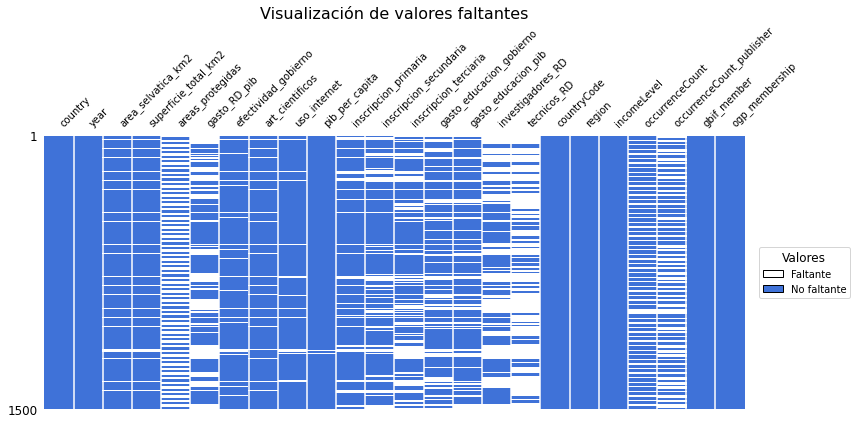

In [9]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 6))
msno.matrix(Data, 
            ax=ax,
            color=(0.25, 0.45, 0.85), 
            sparkline=False,
            fontsize=10)

# Crear leyenda personalizada
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Faltante'),
    Patch(facecolor=(0.25, 0.45, 0.85), edgecolor='black', label='No faltante')
]

# Añadir leyenda fuera del gráfico
ax.legend(
    handles=legend_elements,
    loc='center left',             # Ubicación relativa
    bbox_to_anchor=(1.02, 0.5),    # Fuera a la derecha, centrada verticalmente
    borderaxespad=0,
    title='Valores',
    fontsize=10,
    title_fontsize=12
)

# Título del gráfico
ax.set_title('Visualización de valores faltantes', fontsize=16)

# Ajustar layout para que no se corte la leyenda
plt.tight_layout()
plt.show()

De forma general, se identifica que hay 1,405 filas con al menos un dato faltante, lo que equivale a un 93.7% de las filas del dataset. La variable objetivo que corresponde al número de registos biológicos publicados por país (_occurrenceCountpublisher_) hay 686 registros (46%) que corresponden a datos faltantes. Esto representa un reto pues disminuye el tamaño del _dataset_ y podría afectar la cantidad de datos disponibles para la construcción y evaluación de los modelos. Sin embargo, hay que considerar que estos vacíos, no se deben a falta de información sino principalmente a la fecha en la que cada país ingreso a la red de GBIF o iniciaron con la publicación de datos a través de esta red. 

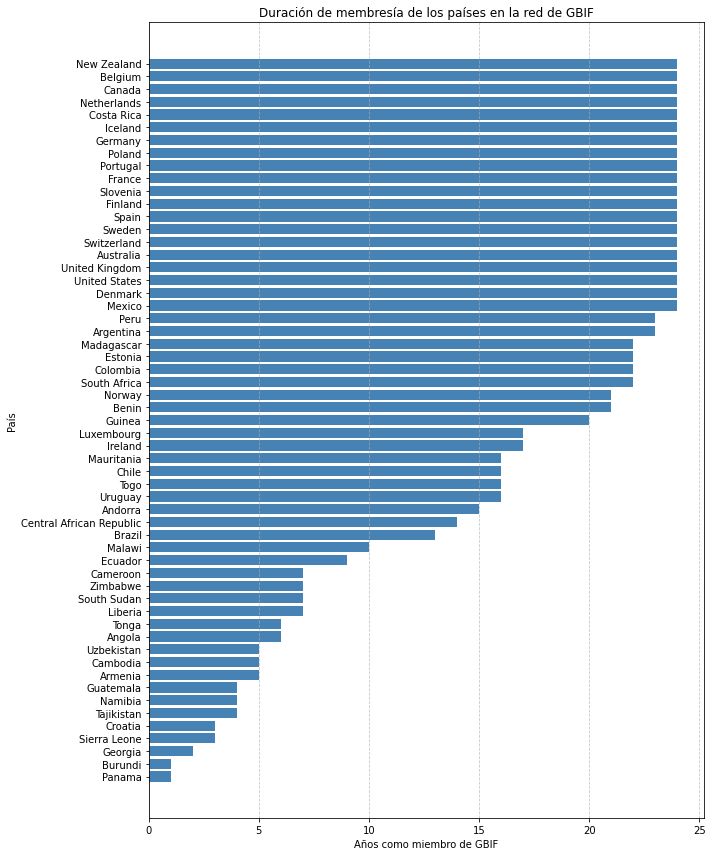

In [10]:



# Filtrar filas donde el país es miembro ("Sí")
Data_members = Data[Data["gbif_member"] == "Sí"]

# Contar los años como miembro por país
membership_duration = Data_members.groupby("country")["year"].count().reset_index()
membership_duration.columns = ["country", "years_in_gbif"]

# Ordenar por duración para mejor visualización
membership_duration = membership_duration.sort_values("years_in_gbif", ascending=True)

# Crear gráfico de barras horizontales
plt.figure(figsize=(10, 12))
plt.barh(membership_duration["country"], membership_duration["years_in_gbif"], color="steelblue")
plt.xlabel("Años como miembro de GBIF")
plt.ylabel("País")
plt.title("Duración de membresía de los países en la red de GBIF")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



In [11]:
membership_duration.describe(include='all')

,country,years_in_gbif
count,57,57.000000
unique,57,NaN
top,Panama,NaN
freq,1,NaN
mean,NaN,16.000000
std,NaN,8.443087
min,NaN,1.000000
25%,NaN,7.000000
50%,NaN,20.000000
75%,NaN,24.000000


Al analizar el gráfico se observa que hay 11 paises que llevan menos de 5 años dentro de la red. Se identifica también que el tiempo promedio de los paíese en el dataset a la red de GBIF es de 16 años con una desviación de 8.5 años, lo que muestra una alta variabilidad en el dataset. Adicionalmente, solo un 25% de los países ha durado más de 24 años y un 25% ha sido miembro de GBIF durante 7 años o menos.    

### Porcentaje de datos faltantes por año:


    year  Porcentaje_faltantes
0   2000             24.583333
1   2001             28.888889
2   2002             24.236111
3   2003             25.277778
4   2004             24.236111
5   2005             24.097222
6   2006             23.680556
7   2007             18.194444
8   2008             17.152778
9   2009             17.083333
10  2010             16.041667
11  2011             14.097222
12  2012             14.722222
13  2013             10.069444
14  2014             10.069444
15  2015              8.888889
16  2016              9.513889
17  2017              7.986111
18  2018              9.652778
19  2019             10.625000
20  2020             10.277778
21  2021             10.486111
22  2022             14.236111
23  2023             39.861111
24  2024             54.097222


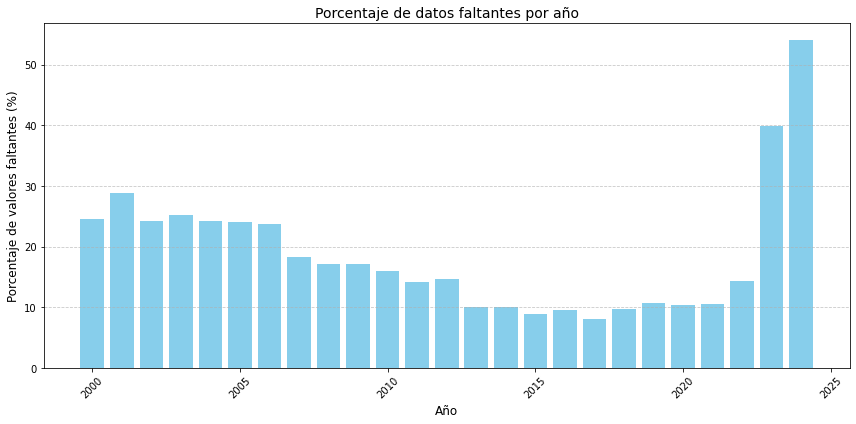

In [12]:
# Asegurarse de que la columna 'year' esté en formato numérico
Data['year'] = pd.to_numeric(Data['year'], errors='coerce')

# Agrupar por año y calcular el porcentaje de valores faltantes por fila
missing_by_year = (
    Data.groupby('year')
    .apply(lambda df: df.isna().sum().sum() / df.size * 100)
    .reset_index(name='Porcentaje_faltantes')
)

# Mostrar resultados ordenados
missing_by_year.sort_values(by='year', inplace=True)
print(missing_by_year)



import matplotlib.pyplot as plt
# --- Gráfico de barras ---
plt.figure(figsize=(12, 6))
plt.bar(missing_by_year['year'], missing_by_year['Porcentaje_faltantes'], color='skyblue')
plt.title('Porcentaje de datos faltantes por año', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Porcentaje de valores faltantes (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Al revisar el volumen de datos faltantes por año se identificó que los primeros 7 años de la serie (2000 - 2006), y especialmente los últimos años (2023-204), tienen el mayor porcentaje de datos faltantes. 

### Datos faltantes por país

Adicionalmente, se consideró relevante analizar si habían países o regiones que aportaran en mayor medida a la presencia de vacíos dentro del conjunto de datos. el siguiente gráfico muestra el número de valores faltantes por país, segementados por región (color). 

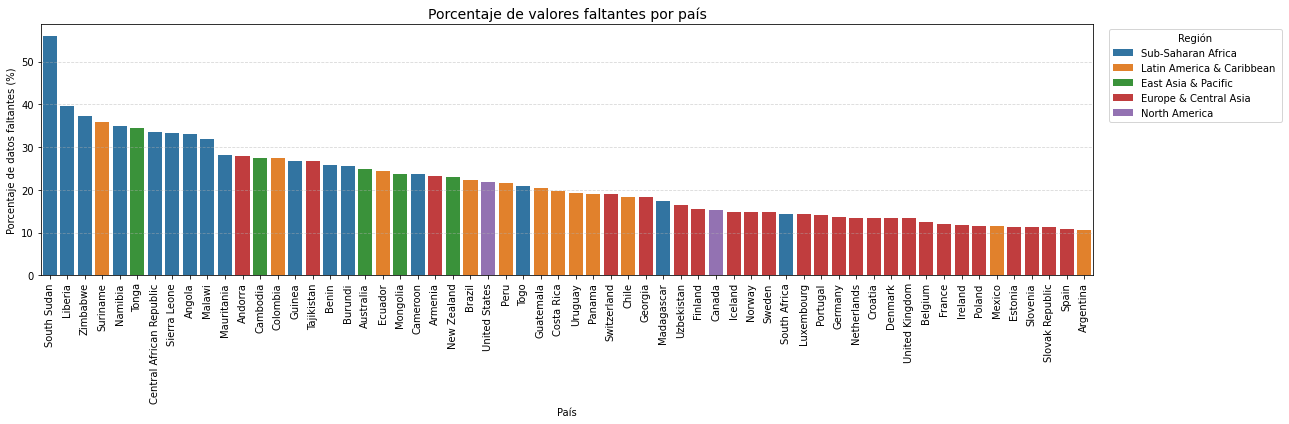

In [13]:


# Calcular número de columnas de datos (excluyendo identificadores)
n_columnas = Data.shape[1] - 3  # Excluye: 'country', 'region', 'countryCode'

# Calcular porcentaje de valores faltantes por país
missing_percent = (
    Data.groupby("country")
    .apply(lambda x: x.isna().sum().sum() / (x.shape[0] * n_columnas) * 100)
    .reset_index(name="missing_percent")
)

# Añadir región correspondiente a cada país
missing_percent = Data[['country', 'region']].drop_duplicates().merge(missing_percent, on='country')

# Ordenar por porcentaje de faltantes
missing_percent = missing_percent.sort_values('missing_percent', ascending=False)

# Graficar
plt.figure(figsize=(18, 6))
sns.barplot(data=missing_percent, x='country', y='missing_percent', hue='region', dodge=False)

plt.title("Porcentaje de valores faltantes por país", fontsize=14)
plt.xlabel("País")
plt.ylabel("Porcentaje de datos faltantes (%)")
plt.xticks(rotation=90)
plt.legend(title='Región', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


El anterior gráfico nos permite identificar cuáles regiones y los respectivos países que presentan el mayor número de datos faltantes. El resultado es que la región del África Subsahariana es la que presenta mayores vacíos, especialmente países como Sudán del Sur. Algunos países de Latinoamérica como Suriname (SR) e incluso Colombia (CO), que es el país sobre el cuál se quieren proyectar los resultados de publicación de datos sobre biodiversidad, tienen grandes vacíos de datos. 

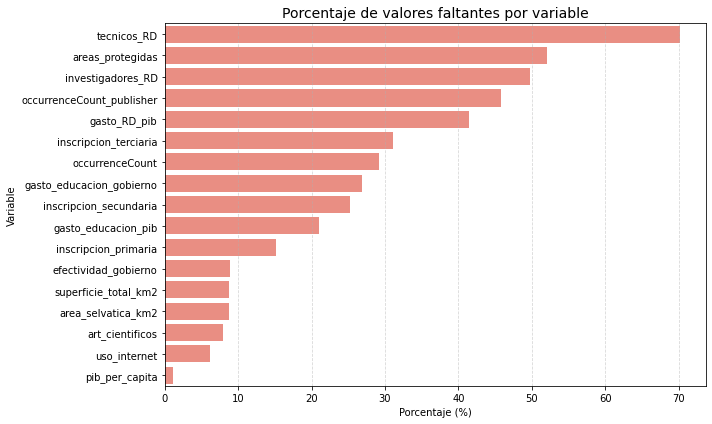

In [14]:
# Calcular porcentaje de celdas vacías por columna
missing_percent = 100 * Data.isna().sum() / len(Data)

# Crear tabla ordenada y redondeada
missing_table = (
    missing_percent[missing_percent > 0]  # Filtrar solo las columnas con faltantes
    .sort_values(ascending=False)         # Ordenar de mayor a menor
    .round(2)                             # Redondear a 2 decimales
    .reset_index()                        # Convertir a DataFrame
)

# Renombrar columnas para presentación
missing_table.columns = ['Variable', 'Porcentaje de valores faltantes (%)']

# Gráfico de porcentaje de valores faltantes por variable
plt.figure(figsize=(10, 6))
sns.barplot(
    data=missing_table,
    y='Variable',
    x='Porcentaje de valores faltantes (%)',
    color='salmon'
)

plt.title('Porcentaje de valores faltantes por variable', fontsize=14)
plt.xlabel('Porcentaje (%)')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **Análisis de los valores faltantes por categoría temática**

**Ciencia y tecnología**:  Estas variables  presentan los mayores niveles de datos faltantes en el conjunto. Por ejemplo, el porcentaje de vacíos en la variable sobre técnicos dedicados a investigación y desarrollo (SP.POP.TECH.RD.P6) alcanza un 70,13%, mientras que la proporción de investigadores por millón de habitantes (SP.POP.SCIE.RD.P6) muestra un 49,73% de ausencia. A su vez, el gasto en investigación y desarrollo como porcentaje del PIB (GB.XPD.RSDV.GD.ZS) tiene un 41,4% de valores faltantes, y los artículos científicos publicados (IP.JRN.ARTC.SC) un 8%.  Sin embargo, otras variables como los artículos científicos publicados (IP.JRN.ARTC.SC) tiene una relación de vacíos de apenas un 8%. 

**Cambio climático y medio ambiente**: La variable que reporta el porcentaje de áreas protegidas terrestres y marinas (ER.PTD.TOTL.ZS) presenta un 52% de datos faltantes. En contraste, otras variables como la cobertura boscosa (AG.LND.FRST.K2) y la superficie total del país (AG.SRF.TOTL.K2) tienen menos del 9% de valores faltantes, lo que las convierte en insumos más confiables para posteriores análisis. Este contraste sugiere que las variables vinculadas a decisiones políticas (como la creación de áreas protegidas) pueden no estar los suficientemente documentadas para contemplarlas en el modelo.

**Educación**: La inscripción escolar en el nivel terciario (SE.TER.ENRR) tiene un 31,07% de datos faltantes, mientras que la inscripción en educación secundaria (SE.SEC.ENRR) y primaria (SE.PRM.ENRR) presentan 25,2% y 15,2% respectivamente. Asimismo, los indicadores de gasto público en educación, tanto como porcentaje del PIB (SE.XPD.TOTL.GD.ZS) como del gasto total del gobierno (SE.XPD.TOTL.GB.ZS), muestran vacíos inferiores al 30%.

**Economía y crecimiento**: La variable sobre el PIB per cápita (NY.GDP.PCAP.CD) tiene un nivel relativamente bajo de datos faltantes (5,13%), lo cual es consistente con su importancia en reportes económicos internacionales y la frecuencia con que es actualizada. Esto la convierte en una de las variables más completas y confiables del conjunto.

**Infraestructura**: El porcentaje de individuos que utilizan internet (IT.NET.USER.ZS) presenta un 6,13% de valores faltantes, lo cual indica una buena cobertura de datos para este indicador. Su estabilidad permite utilizarlo como un proxy útil para analizar aspectos de acceso digital o desarrollo tecnológico en general.

**Sector público**: La variable que mide la efectividad del gobierno (GE.EST) tiene una tasa de valores faltantes del 8,87%, lo cual, si bien no es despreciable, aún permite su utilización en análisis comparativos. No obstante, su carácter estimado y subjetivo implica considerar también las fuentes y metodologías de cálculo antes de usarla como variable explicativa.

**Datos de biodiversidad (GBIF)**: Cómo se observó anterioremente los datos de ocurrencias de biodiversidad —como occurrenceCount y occurrenceCount_publisher— presentan vacíos importantes (29,2% y 45,73%, respectivamente). Los vacíos en estas variables pueden tener implicaciones importantes en la representatividad de los análisis relacionados con disponibilidad y movilización de datos sobre biodiversidad.

## Identifiacación de valores atípicos y sesgos en los datos

La identificación de valores atípicos es una etapa clave en el análisis exploratorio de datos, ya que estos pueden reflejar errores de medición, codificación inadecuada, o bien fenómenos reales pero extremos que requieren especial atención. En el contexto de este análisis, la detección de outliers permite evaluar la consistencia de las variables cuantitativas, identificar posibles sesgos en los datos y considerar decisiones sobre su tratamiento. Además, los valores extremos pueden tener un impacto significativo en estadísticas descriptivas y en la generación de modelos, por lo que su análisis resulta fundamental para asegurar la calidad y robustez de los resultados. A continuación se realiza un análisis general o global de las variables y su comportamiento, sin segmentar por región o país. 

In [22]:
# Variables numéricas 
var_num = [
    'art_cientificos',
    'investigadores_RD',
    'gasto_RD_pib',
    'tecnicos_RD',
    'pib_per_capita',
    'gasto_educacion_pib',
    'inscripcion_primaria',
    'inscripcion_secundaria',
    'inscripcion_terciaria',
    'gasto_educacion_gobierno',
    'areas_protegidas',
    'area_selvatica_km2',
    'superficie_total_km2',
    'efectividad_gobierno',
    'uso_internet',
    'occurrenceCount', 
    'occurrenceCount_publisher'
]
var_num_t = Data[var_num]

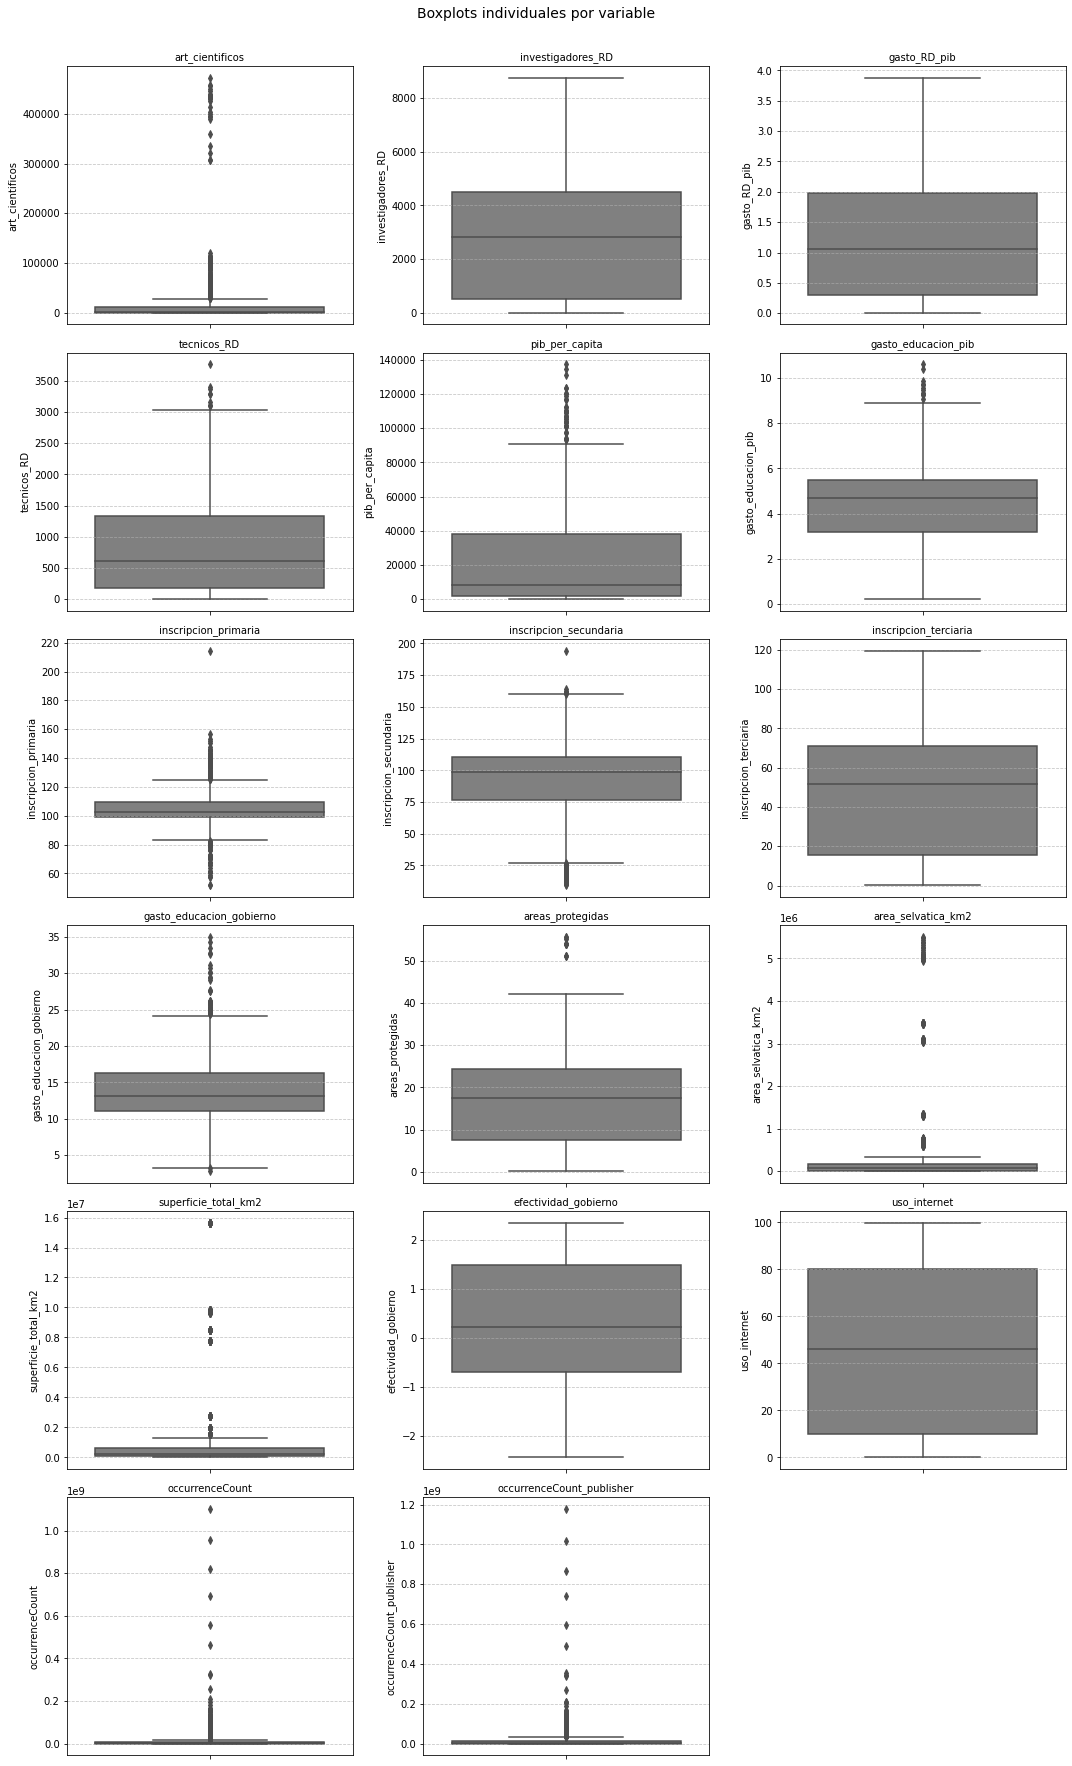

In [23]:
# Número de variables
num_vars = var_num_t.shape[1]
cols = 3  # Número de columnas en el mosaico
rows = math.ceil(num_vars / cols)

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Crear un boxplot por variable
for i, col in enumerate(var_num_t.columns):
    sns.boxplot(data=var_num_t, y=col, ax=axes[i], color='grey')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplots individuales por variable", fontsize=14, y=1.02)
plt.show()


Dentro de las variables socioeconómicas las variables AG.LND.FRST.K2 (Área selvática (kilómetros cuadrados)) y AG.SRF.TOTL.K2 (Superficie (kilómetros cuadrados)) presentan la mayor cantidad de valores atípicos reflejando la diversidad de extensión en área de los países y su respectivo extensión en áreas selváticas. Esto se cosidera normal y no representa un error que requiera de posteriores ajustes. 

De igual manera, variables asociadas a los artículos en publicaciones científicas y técnicas (IP.JRN.ARTC.SC), Gasto público en educación, total (% del PIB) () y la Inscripción escolar, nivel primario (% bruto) (SE.PRM.ENRR) presentan una alta variabilidad y cantidad de datos atípicos al analizarse de forma global. Por lo que se hace un análisis por regiones paara evaluar su comportamiento.  

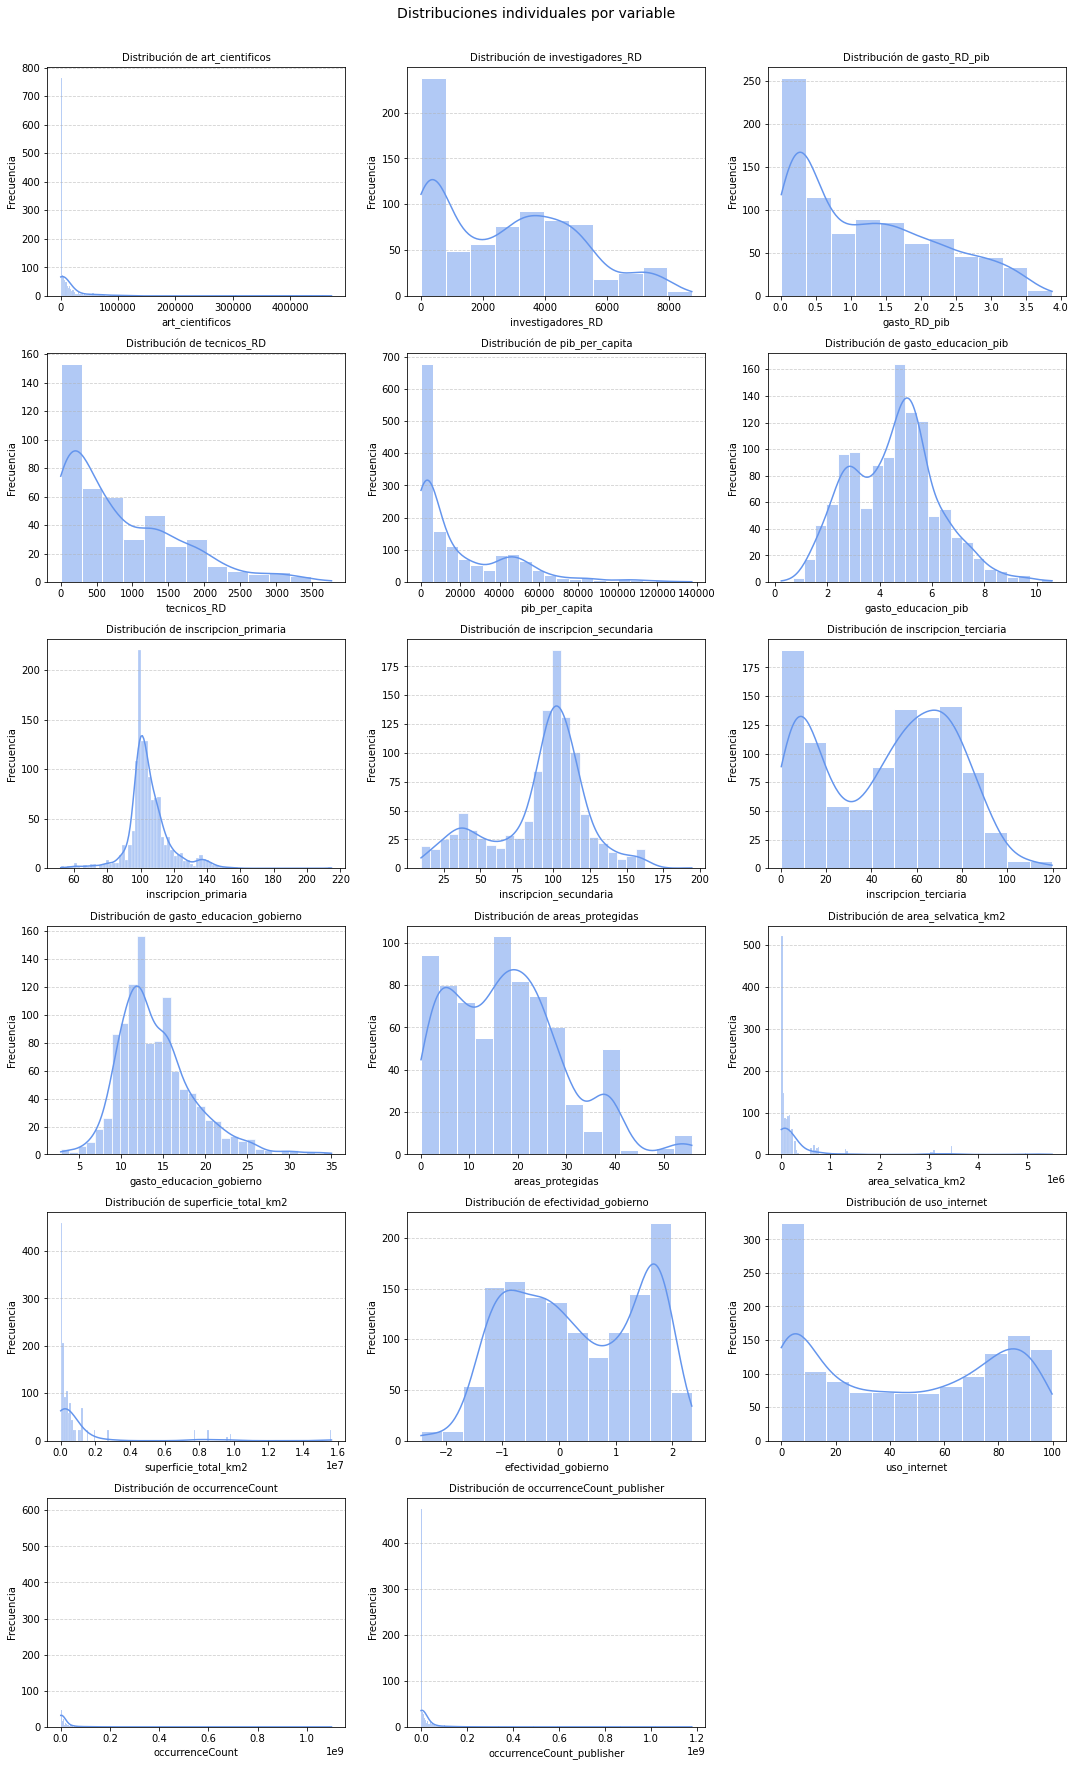

In [24]:
# Visualización de distribuciones individuales por variable numérica
# Número de variables
num_vars = var_num_t.shape[1]
cols = 3  # Número de columnas en el mosaico
rows = math.ceil(num_vars / cols)

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Crear un histograma + KDE por variable
for i, col in enumerate(var_num_t.columns):
    sns.histplot(data=var_num_t, x=col, kde=True, ax=axes[i], color='cornflowerblue', edgecolor='white')
    axes[i].set_title(f'Distribución de {col}', fontsize=10)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribuciones individuales por variable", fontsize=14, y=1.02)
plt.show()


A continuación se realiza un análisis teniendo en cuenta que el análisis por regiones geográficas puede permitir entender mejor las variables por la similitud de su comportamiento a nivel regional. 

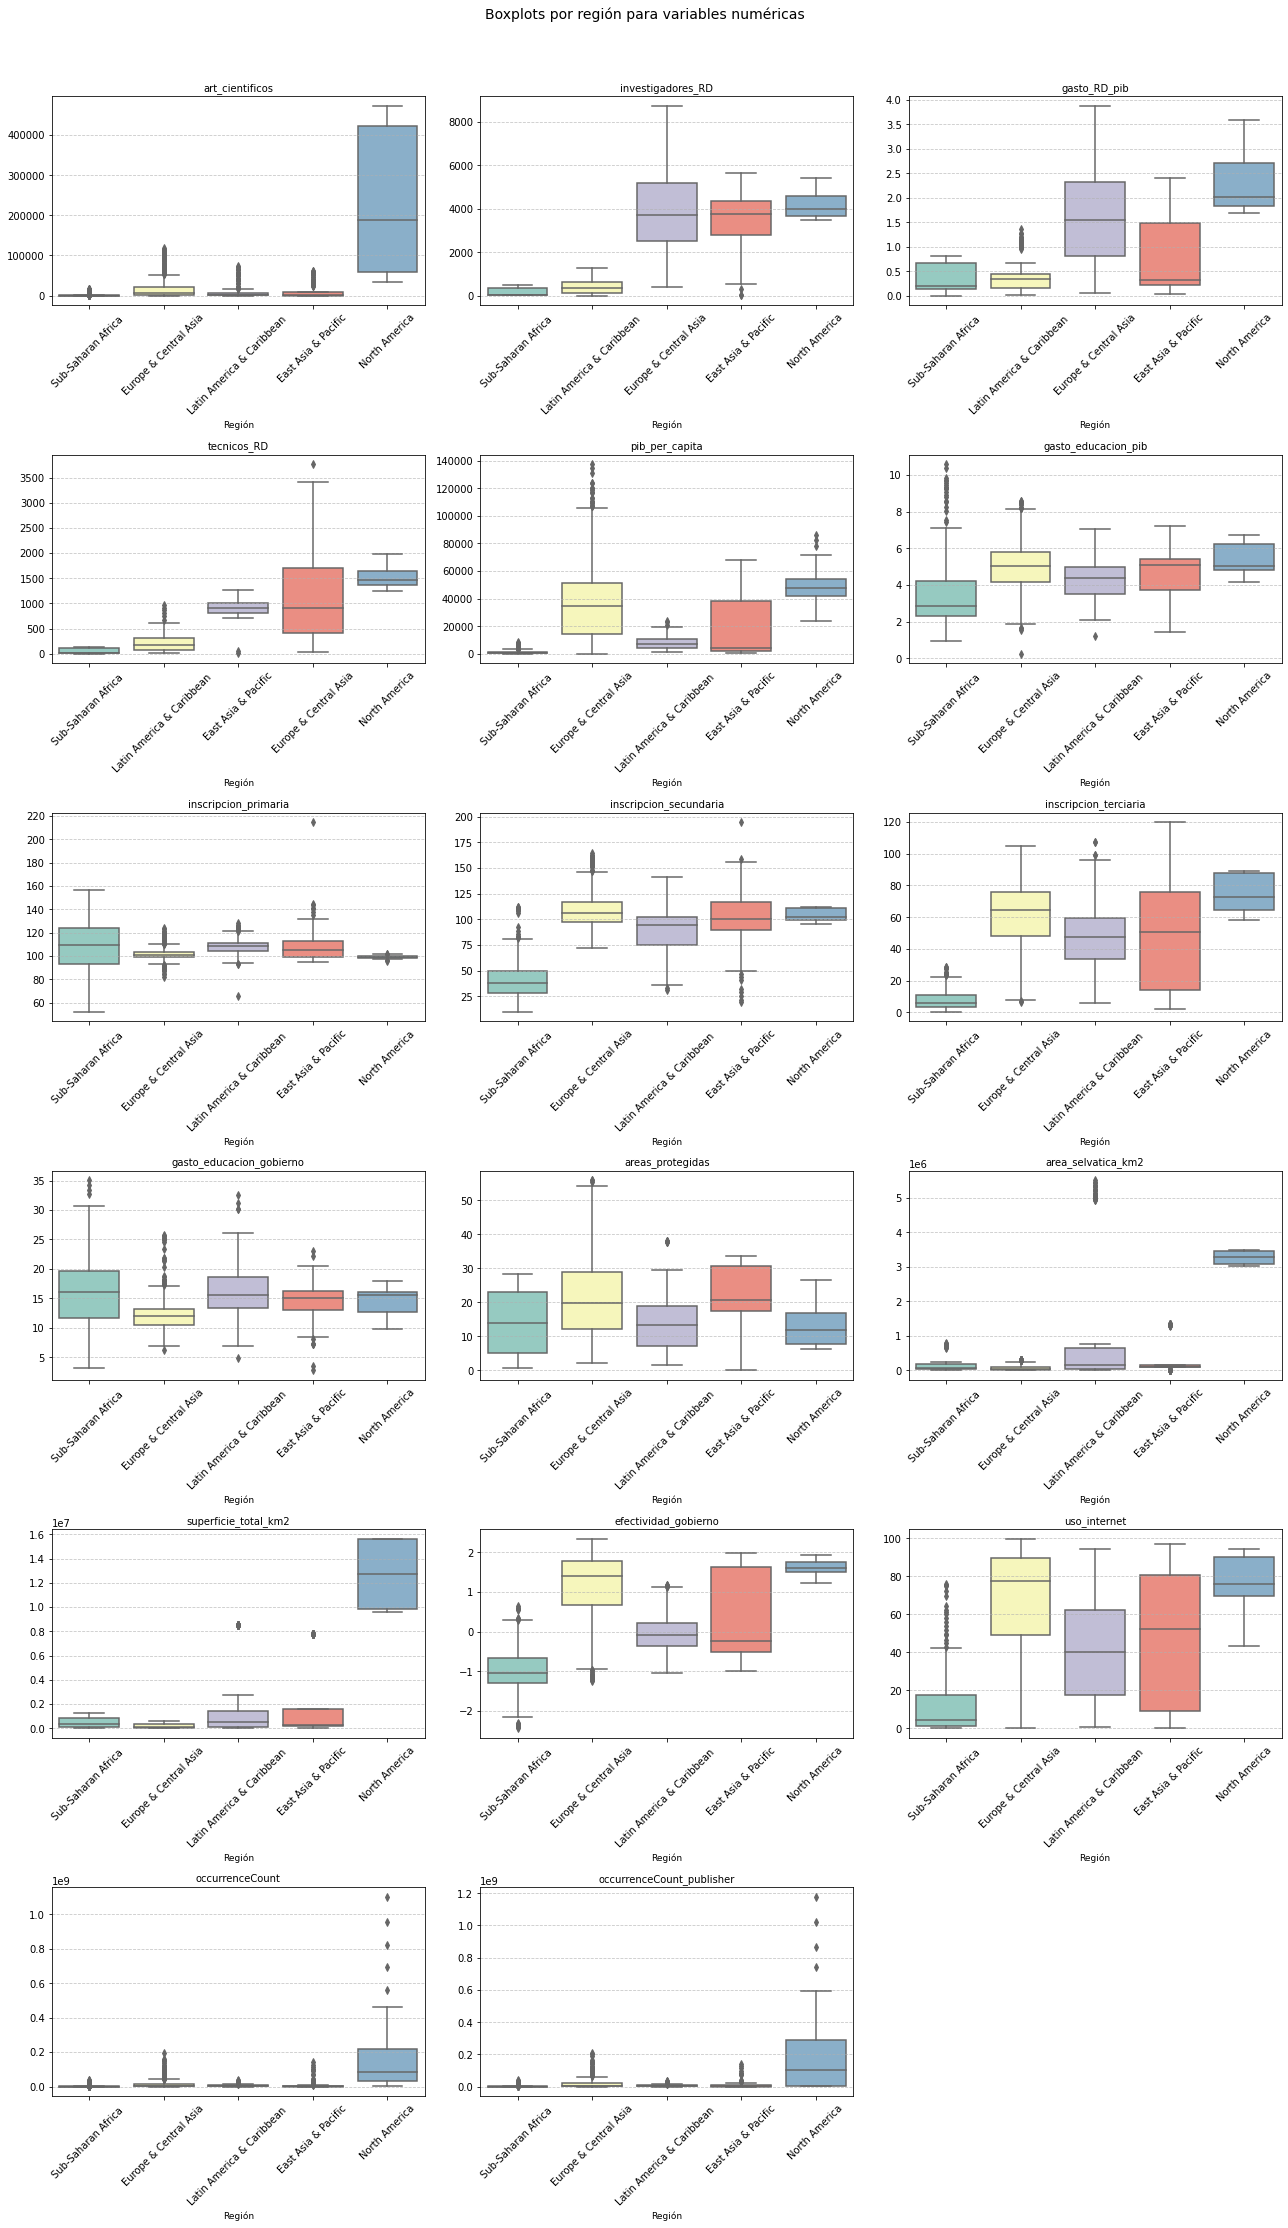

In [25]:


# Número de variables numéricas a graficar
num_vars = var_num_t.shape[1]
cols = 3  # Columnas del mosaico
rows = math.ceil(num_vars / cols)

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

# Boxplot por variable, desagregado por región
for i, col in enumerate(var_num_t.columns):
    # Combinar la variable numérica con la columna 'region'
    df_plot = pd.concat([Data[['region']], Data[[col]]], axis=1)
    df_plot = df_plot.dropna()  # Eliminar filas con NaN

    sns.boxplot(data=df_plot, x='region', y=col, ax=axes[i], palette='Set3')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('Región', fontsize=9)
    axes[i].set_ylabel('', fontsize=9)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar subplots vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplots por región para variables numéricas", fontsize=14, y=1.03)
plt.show()


### Correlación de las variables

A continuación se realiza un análisis de correlación entre las variables numéricas.

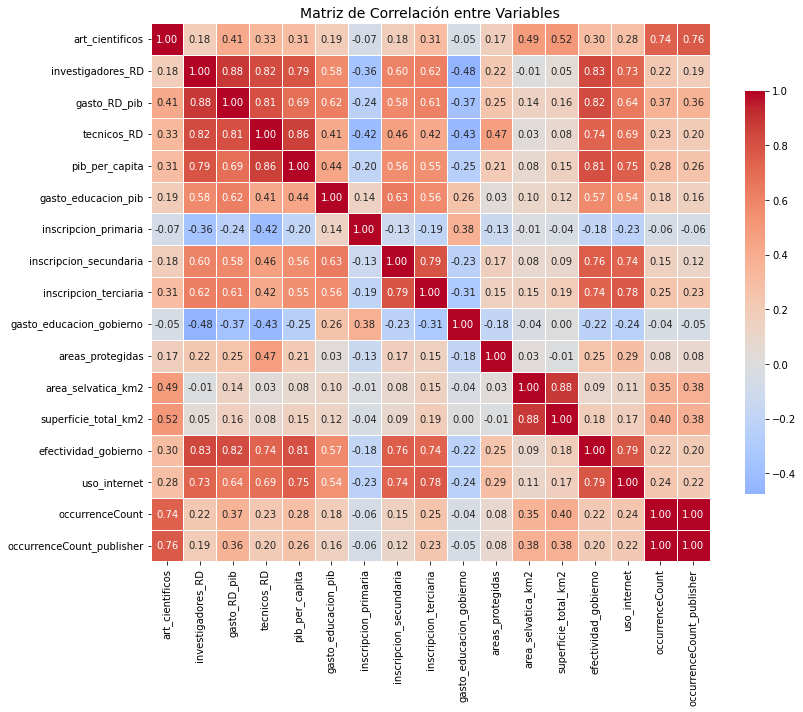

In [26]:


# Calcular matriz de correlaciones
corr_matrix = var_num_t.corr()

# Crear mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,              # Muestra los valores numéricos
    fmt=".2f",               # Formato de los números
    cmap="coolwarm",         # Paleta de colores
    center=0,                # Centra el color en 0
    linewidths=0.5,          # Líneas divisorias
    cbar_kws={"shrink": 0.75}  # Tamaño de la barra de color
)

plt.title("Matriz de Correlación entre Variables", fontsize=14)
plt.tight_layout()
plt.show()


El gráfico representa una matriz de correlación entre variables socioeconómicas del Banco Mundial y dos variables relacionadas con publicaciones de datos de biodiversidad desde GBIF:

- _occurrenceCount_: número de registros de biodiversidad ocurridos en un país.
- _occurrenceCount_publisher_: número de registros publicados por instituciones de un país.

Análisis general del gráfico

- _Alta correlación entre variables educativas y científicas_: SP.POP.SCIE.RD.P6 (investigadores) y GB.XPD.RSDV.GD.ZS (gasto en I+D): 0.88, mientras que IP.JRN.ARTC.SC (artículos científicos) se correlaciona muy bien con SP.POP.SCIE.RD.P6: 0.83, GB.XPD.RSDV.GD.ZS: 0.82 y SE.TER.ENRR (educación terciaria): 0.73. Esto muestra un resultado esperado donde los países con mayor inversión en investigación y más investigadores también producen más publicaciones científicas.

- _Correlaciones moderadas con las variables de GBIF_: occurrenceCount_publisher tiene correlaciones más altas con IP.JRN.ARTC.SC: 0.76, SP.POP.SCIE.RD.P6: 0.74, GB.XPD.RSDV.GD.ZS: 0.74 y SE.TER.ENRR: 0.69. Esto muestra que la capacidad de publicar datos de biodiversidad está asociada con la inversión científica y la producción de conocimiento. Esto sugiere que una base científica sólida favorece el rol activo de un país como publicador de datos. Además, occurrenceCount (datos ocurridos en el país): Se correlaciona bien conn SE.TER.ENRR: 0.64,  IP.JRN.ARTC.SC: 0.62, GB.XPD.RSDV.GD.ZS: 0.58 y SP.POP.SCIE.RD.P6: 0.54. Mostrando que el número de registros ocurridos también tiene un vínculo con variables de educación y ciencia, aunque de forma más tenue. Esto puede deberse a que no todos los registros son generados por capacidades nacionales; pueden depender también de esfuerzos externos o colaborativos.

- _Baja correlación con variables ambientales directas: AG.SRF.TOTL.K2, AG.LND.FRST.K2, ER.PTD.TOTL.ZS tienen correlaciones bajas o negativas con las variables de GBIF, esto posiblemente se debe a que la extensión territorial o la proporción de áreas protegidas no garantizan una alta publicación ni un alto número de registros, lo que sugiere que la disponibilidad de datos no solo depende de la biodiversidad presente, sino también de la capacidad de monitoreo y movilización de datos, lo cuál es congruente con la tendencia histórica de mayo publicación de datos en países que no necesariamente son _Hot spots_ de Biodiversidad.


Aunque hay una alta proporción de datos ausentes se lograron encontrar correlaciones coherentes y fuertes entre algunas variables, esto puede ser una  señal de que los datos aunque pocos, son significativos y capturan patrones. Sin embargo, es importante analizar si los datos faltantes tienen un comportamiento aleatorio puesto que si los datos faltan de forma no aleatoria (por ejemplo, ciertos países o años con condiciones particulares), lass correlaciones pueden estar sesgadas. A continuación se explora el comportamiento de los datos faltantes.

#### Correlación de ausencias

El missingno.correlatio_matrix() genera una matriz de correlación entre ausencias, es decir, responde a la pregunta ¿Con qué frecuencia se ausenta una variable al mismo tiempo que otra?. Se basa generalmente en el coeficiente de correlación de Pearson entre vectores binarios (1 = presente, 0 = ausente). Tener enc uenta que este test se aplica solo sobre los valores numéricos debido a la naturaleza del test. No se consideró sobre las variables categóricas (usando one hot encoding para transformar las variables) debido a que las variables categóricas no presentan ausencias como se mostró anteriormente. 

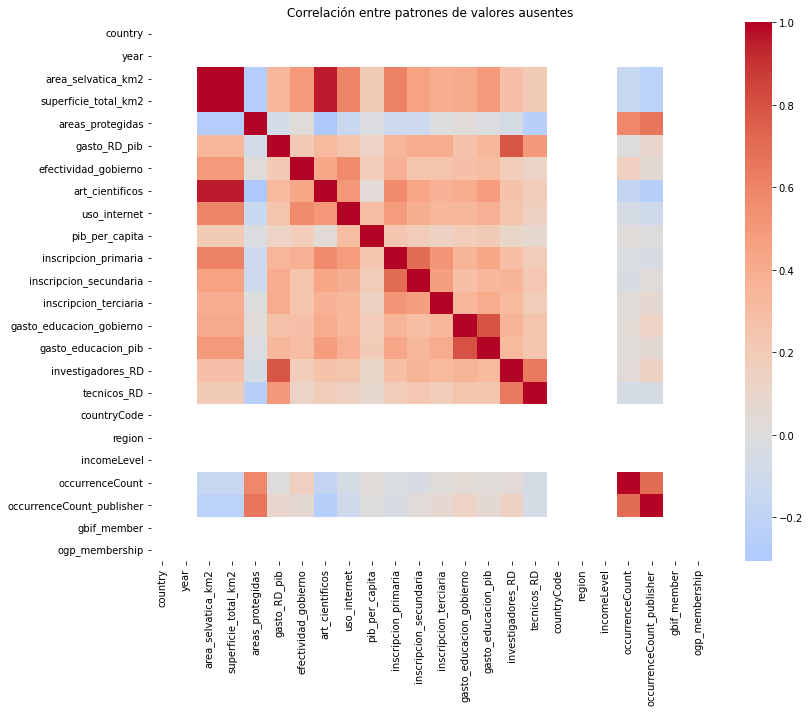

In [37]:


# Matriz booleana de ausencias
missing_bool = Data.isna()

# Calcular correlación de ausencias
missing_corr = missing_bool.corr()

# Graficar
plt.figure(figsize=(12, 10))
sns.heatmap(missing_corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlación entre patrones de valores ausentes")
plt.tight_layout()
plt.show()

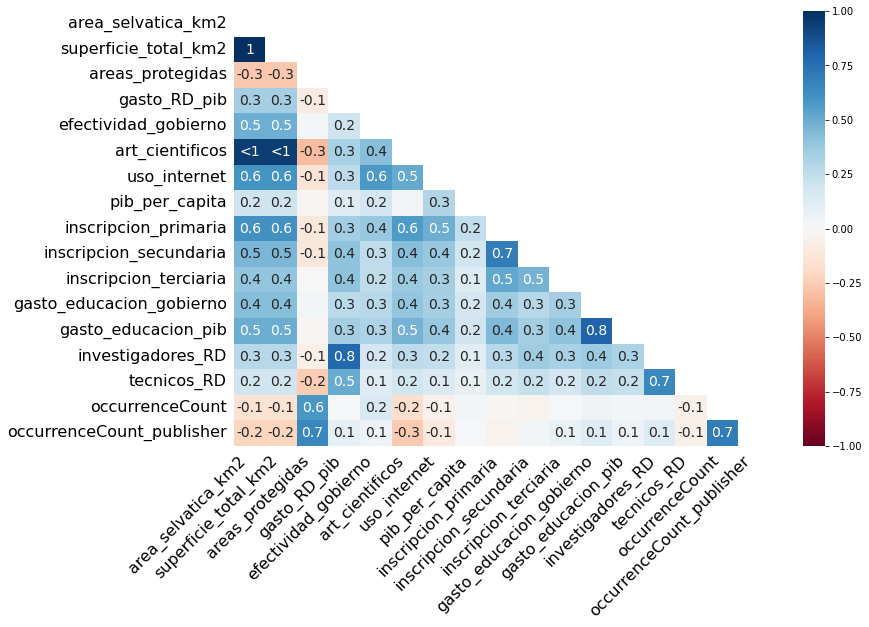

In [ ]:
# Mapa de calor de correlación de ausencias con missingno.
msno.heatmap(Data, figsize=(12, 8))
plt.show()


A partir del gráfico se observa que la mayoría de las correlaciones de ausencias son positivas, es decir que si falta un valor es probable que el otro también falte. Adicionalmente, se observa que hay variables fuertemente correlacionadas por ausencias. 

Adicionalmente, las ausencias en las variables objetivo no están relacionadas con las ausencias de otras variables del dataset. Es decir, no hay un patrón claro o dependiente de otras variables en cuanto a qué datos están ausentes. Ademas, las ausencias en la variable objetivo no se correlacionan con las ausencias de otras variables, esto puede apoyar (aunque no confirmar) la hipótesis de que los datos faltan completamente al azar (MCAR) respecto a esa variable.


El siguiente código evalúa si los datos faltantes son completamente aleatorios. Para ello se implementa el test de _Little MCAR_ Aunque se aplica de forma manual porque las librerías como missingpy ya no son compatibles con las versiones recientes de scikit-learn. El resultado del test de Little para MCAR (Missing Completely At Random) indica si los datos faltantes en tu conjunto pueden considerarse completamente al azar, es decir, si la probabilidad de que falte un valor no depende ni de los valores observados ni de los no observados.

Por último, la variable objetivo no está relacionada con el patrón de ausencias de los predictores, entonces al imputar o eliminar valores faltantes en los predictores probablemente no se introducirá sesgo en los modelos de predicción.

In [38]:

def little_mcar_test(data):
    # Filtrar columnas numéricas
    data = data.select_dtypes(include=[np.number])

    # Crear patrón de ausencias para cada fila (True = faltante, False = presente)
    patterns = data.isnull().astype(int)
    patterns['pattern'] = patterns.apply(lambda row: ''.join(row.astype(str)), axis=1)
    
    # Agrupar por patrón de ausencias
    grouped = data.copy()
    grouped['pattern'] = patterns['pattern']
    groups = grouped.groupby('pattern')

    # Calcular estadísticas
    chi_square = 0
    df = 0
    overall_mean = data.mean(skipna=True)

    for name, group in groups:
        # Subset sin valores faltantes
        complete = group.drop(columns='pattern').dropna(axis=1, how='any')
        if complete.shape[1] == 0:
            continue  # Saltar patrones sin columnas completas

        n_i = complete.shape[0]
        mean_i = complete.mean()

        # Solo columnas que están completas en este grupo
        cols = complete.columns
        s_i = complete.cov().values  # Matriz de covarianza del grupo
        mean_diff = (mean_i - overall_mean[cols]).values.reshape(-1, 1)

        try:
            inv_s_i = np.linalg.pinv(s_i)
            chi_i = n_i * mean_diff.T @ inv_s_i @ mean_diff
            chi_square += chi_i.item()
            df += len(cols)
        except np.linalg.LinAlgError:
            continue

    p_value = 1 - chi2.cdf(chi_square, df)

    return {
        'Chi2': chi_square,
        'df': df,
        'p-value': p_value
    }

result = little_mcar_test(Data)
print(f"Little's MCAR test manual:\nChi² = {result['Chi2']:.2f}, df = {result['df']}, p = {result['p-value']:.4f}")


/Users/ricardoortiz/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/ricardoortiz/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/ricardoortiz/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Little's MCAR test manual:
Chi² = 195097631190.20, df = 1754, p = 0.0000




A continuación se analizan los resultados del test:

Chi² muy alto: El valor del estadístico Chi-cuadrado es extremadamente alto, lo que sugiere una gran discrepancia entre los patrones de datos faltantes y lo que se esperaría si los datos faltaran completamente al azar.

p-valor ≈ 0.0000: Es significativamente menor que cualquier umbral típico (como 0.05, 0.01 o incluso 0.001).

Por lo tanto se rechaza la hipótesis nula de que los datos faltan completamente al azar. En otras palabras, los datos faltantes no son completamente aleatorios. 

RESULTADO A DISCUTIR. NO TIENE MUCHO SENTIDO QUE NO SEAN ALEATORIOS O QUIZÁS ESTA RELACIONADO CON LAS REGIONES O PAÍSES QUE TIENEN VALORES FALTANTES.

## Análisis de variables categóricas

Ahora se procede a analizar la distribución de las variables categóricas incluidas dentro del conjunto de datos.

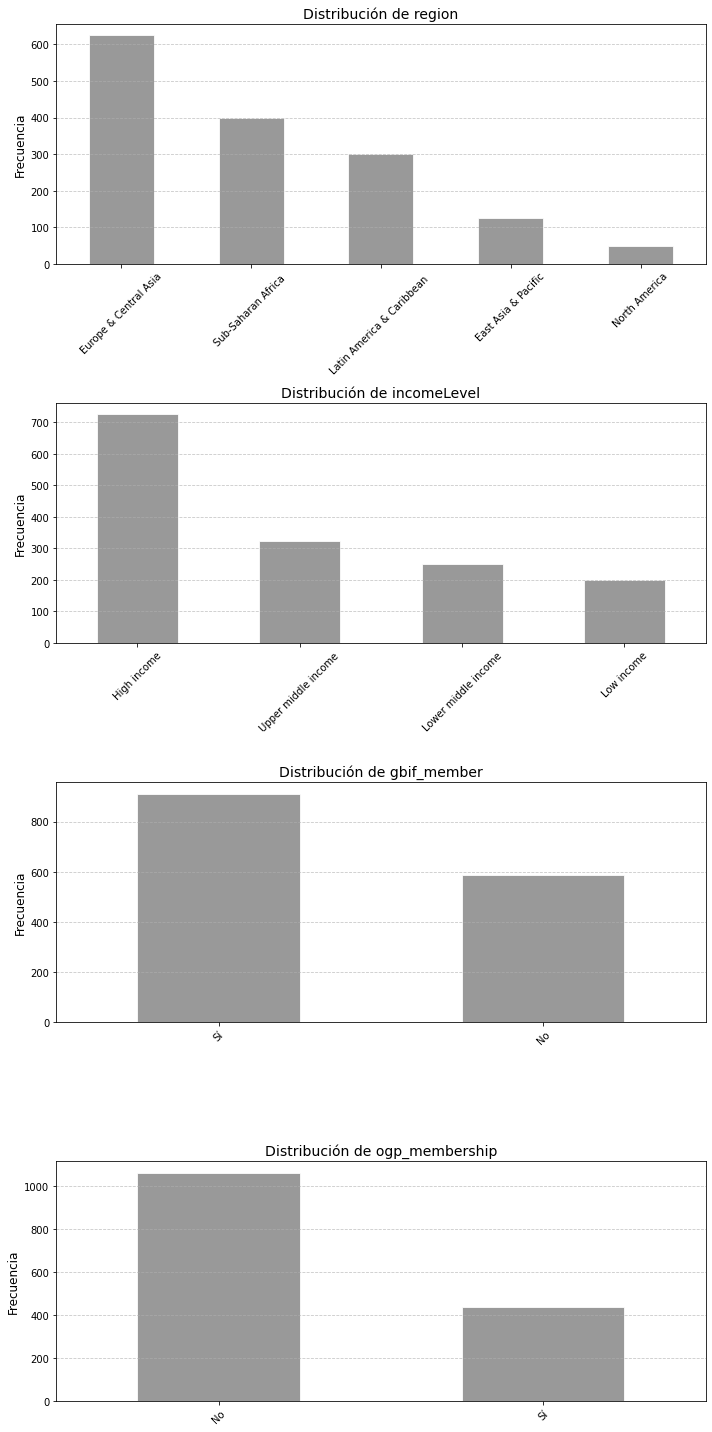

In [29]:

# Variables categóricas a graficar
var_cat_BM = ['region', 'incomeLevel', 'gbif_member', 'ogp_membership']
cat_vars = Data[var_cat_BM]

# Crear subplots (uno por variable categórica)
fig, axes = plt.subplots(len(cat_vars.columns), 1, figsize=(10, 5 * len(cat_vars.columns)))

# Asegurar que axes siempre sea iterable
if len(cat_vars.columns) == 1:
    axes = [axes]

# Graficar cada variable
for ax, col in zip(axes, cat_vars.columns):
    counts = Data[col].value_counts(dropna=False)
    counts.plot(kind='bar', ax=ax, color='grey', edgecolor='white', alpha=0.8)

    ax.set_title(f'Distribución de {col}', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas si son largas

plt.tight_layout()
plt.show()

La compilación de las fuentes de datos sobre biodiversidad de GBIF y las variables socioecnómicas del Banco Mundial, resultó en un archivo de 1500 filas y 25 columnas, que representan los valores de 60 países con datos de una serie de tiempo que cubre desde el año 2.000 hasta el 2024. Los datos representan 5 regiones a nivel global, según la clasificación del Banco Mundial, correspondiendo en su mayoría a Europa & Asia Central (42%), África Sub-Sahariana (27%), Latino América & el Caribe (20%), Asia Oriental y el pacífico y Norte América (12%). 

De igual forma, se identifica que la mayoría de los países en la base de datos son de ingresos altos (47%), medios altos (25%), bajos medios (15%) y bajos ingresos (13%). Esto inicialmente podría mostrar una tendencia en el nivel de ingreso de los países que comparten datos e información a través de la red de GBIF. 

A continuación se genera una matriz de correlación basada en una Matriz de Cramer's V. a partir de variables categóricas. Esta métrica varía entre 0 (sin asociación) y 1 (con asociación) 

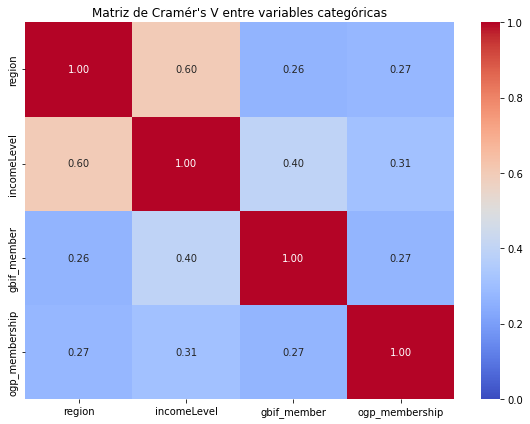

In [30]:

# Función para calcular Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1))) if min(k, r) > 1 else np.nan

# Crear matriz vacía
matrix = pd.DataFrame(index=var_cat_BM, columns=var_cat_BM)

# Calcular Cramér's V para cada par de variables categóricas
for col1 in var_cat_BM:
    for col2 in var_cat_BM:
        matrix.loc[col1, col2] = cramers_v(cat_vars[col1], cat_vars[col2])

# Convertir a tipo float
matrix = matrix.astype(float)

# Graficar matriz de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt=".2f")
plt.title("Matriz de Cramér's V entre variables categóricas")
plt.tight_layout()
plt.show()



### Análisis de la serie temporal

En primer lugar se realiza un gráfico que nos permite analizar la tendencia global de publicación de datos dentro de la serie de tiempo. En este escenario se observa que dentro de los primeros 6 años de la red, no había aún datos publicados. Por lo que se podría evaluar la eliminación de este primer grupo de años de la serie temporal durante la fase de preparación de los datos. 


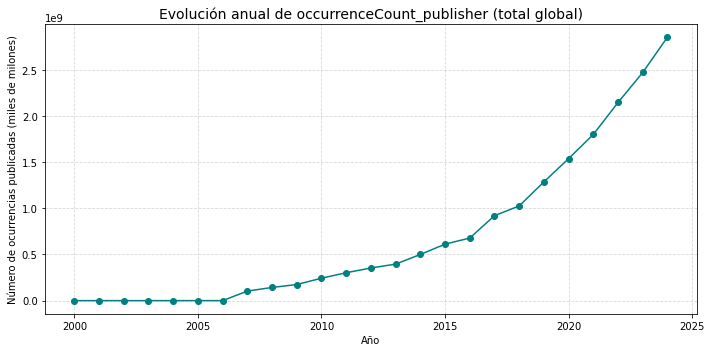

In [ ]:
#Asegurar que la columna year está en formato numérico o de fecha
#df_series = Data.copy()
#df_series['year'] = pd.to_datetime(Data['year'], format='%Y')
#Agrupa los datos por año y suma los valores de occurrenceCount_publisher
serie_occs = Data.groupby('year')['occurrenceCount_publisher'].sum()

#Crear el gráfico de serie de tiempo
plt.figure(figsize=(10, 5))
serie_occs.plot(marker='o', color='teal')
plt.title('Evolución anual de occurrenceCount_publisher (total global)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Número de ocurrencias publicadas (miles de milones)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Ahora se analiza la cantidad de datos movilizados por país. Acá se ve un país con un comportamiento atípico que corresponde a Estados Unidos (EU). Este crecimiento puede estar determinado en gran medidad por la publicación de datos de observaciones de aves a través de la red de eBird. Esto requerirá un análisis posterior para mayor certeza sobre la razón de este comportamiento. 



<Figure size 1008x576 with 0 Axes>

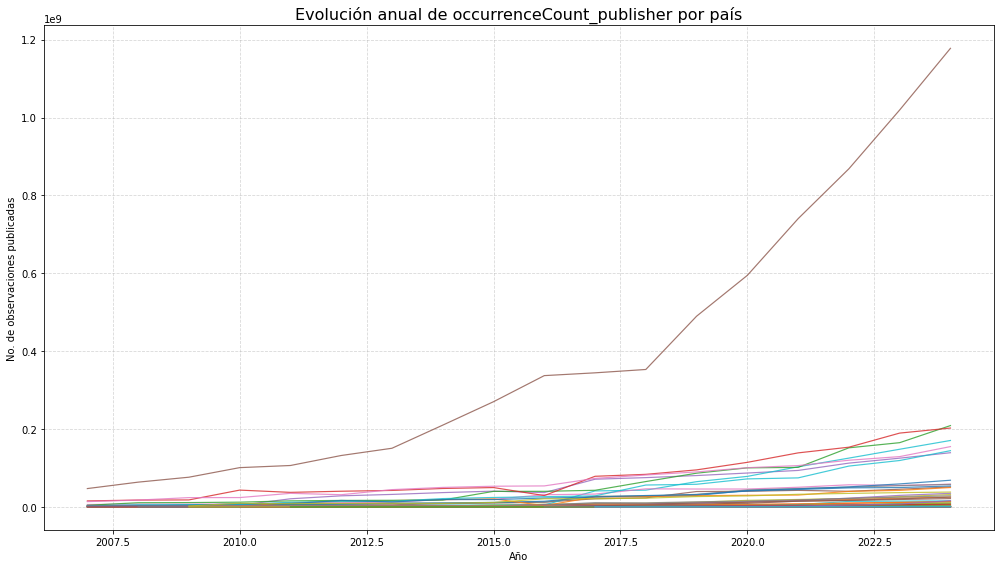

In [48]:

# Reorganizar los datos: años como índice, países como columnas
df_series_country = Data.pivot(index='year', columns='countryCode', values='occurrenceCount_publisher')

# Crear el gráfico
plt.figure(figsize=(14, 8))
df_series_country.plot(figsize=(14, 8), lw=1.2, alpha=0.8, legend=False)  # Sin leyenda para no saturar el gráfico

plt.title('Evolución anual de occurrenceCount_publisher por país', fontsize=16)
plt.xlabel('Año')
plt.ylabel('No. de observaciones publicadas')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Análisis de serie de tiempo según nivel de ingreso de los países

<AxesSubplot:title={'center':'Serie de tiempo: occurrenceCount_publisher por incomeLevel'}, xlabel='year'>

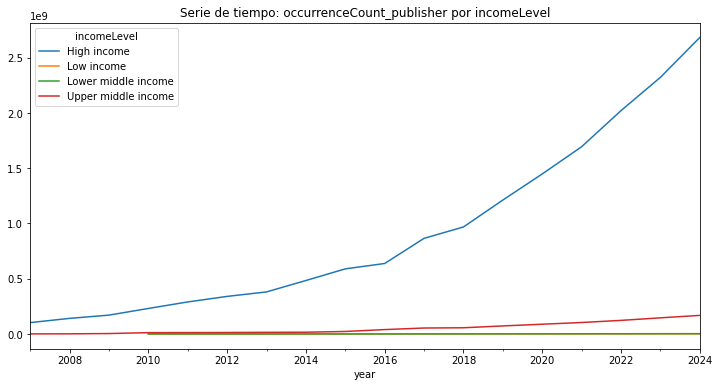

In [49]:

# Asegurar que 'year' es numérico
#Data['year'] = pd.to_numeric(Data['year'], errors='coerce')

# Eliminar filas con year o incomeLevel faltantes
df_serie_il = Data.dropna(subset=['year', 'incomeLevel', 'occurrenceCount_publisher'])

# Agrupar por año e incomeLevel y sumar los conteos
ts_income = (
    df_serie_il.groupby(['year', 'incomeLevel'])['occurrenceCount_publisher']
    .sum()
    .reset_index()
)

# Pivotear para que cada nivel de ingreso sea una columna
ts_income_pivot = ts_income.pivot(index='year', columns='incomeLevel', values='occurrenceCount_publisher')

# Asegurar que el índice es tipo fecha (opcional si usarás análisis de series de tiempo avanzado)
ts_income_pivot.index = pd.to_datetime(ts_income_pivot.index, format='%Y')

# Visualización rápida (opcional)
ts_income_pivot.plot(title="Serie de tiempo: occurrenceCount_publisher por incomeLevel", figsize=(12,6))


Análisis de serie de tiempo en la que se evalua el volumen de publicación por región

<AxesSubplot:title={'center':'Serie de tiempo: occurrenceCount_publisher por región'}, xlabel='year'>

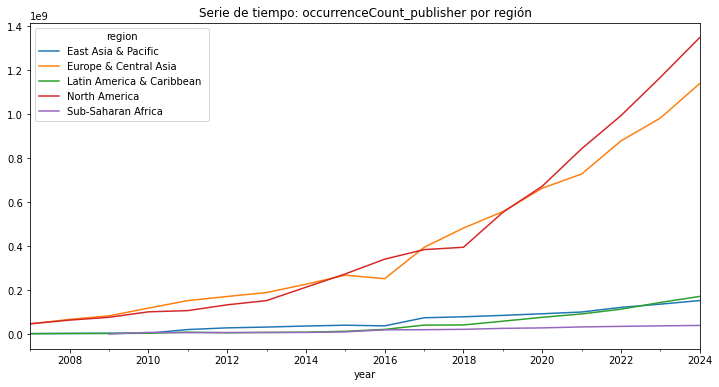

In [50]:
# Asegurar que 'year' es numérico
#Data['year'] = pd.to_numeric(Data['year'], errors='coerce')

# Eliminar filas con year o incomeLevel faltantes
df_serie_reg = Data.dropna(subset=['year', 'region', 'occurrenceCount_publisher'])

# Agrupar por año e incomeLevel y sumar los conteos
ts_income = (
    df_serie_il.groupby(['year', 'region'])['occurrenceCount_publisher']
    .sum()
    .reset_index()
)

# Pivotear para que cada nivel de ingreso sea una columna
ts_income_pivot = ts_income.pivot(index='year', columns='region', values='occurrenceCount_publisher')

# Asegurar que el índice es tipo fecha (opcional si usarás análisis de series de tiempo avanzado)
ts_income_pivot.index = pd.to_datetime(ts_income_pivot.index, format='%Y')

# Visualización rápida (opcional)
ts_income_pivot.plot(title="Serie de tiempo: occurrenceCount_publisher por región", figsize=(12,6))

In [58]:


# Obtener lista de años como array (para traducir índices a años)
years = df_series_country.index.to_list()

# Diccionario para guardar los puntos de cambio con año por país
change_points_by_country = {}

# Iterar por cada país (columna del DataFrame)
for country in df_series_country.columns:
    signal = df_series_country[country].fillna(0).values

    # Ajustar modelo de detección de cambio (cambios en la media)
    algo = rpt.Pelt(model="l2").fit(signal)
    
    # Detectar puntos de cambio (ajusta el valor de 'pen' si hay sobreajuste o subdetección)
    change_indices = algo.predict(pen=20)

    # Traducir índices a años (excepto el último punto que es el final de la serie)
    change_years = [years[i - 1] for i in change_indices if i < len(years)]
    
    # Guardar resultados
    change_points_by_country[country] = change_years

# Mostrar resumen
for country, change_years in change_points_by_country.items():
    print(f"{country}: {change_years}")


AD: [2009, 2014, 2019]
AM: [2014, 2019]
AO: [2014, 2019]
AR: [2004, 2009, 2014, 2019]
AU: [2004, 2009, 2014, 2019]
BE: [2004, 2009, 2014, 2019]
BI: [2014, 2019]
BJ: [2009, 2014, 2019]
BR: [2009, 2014, 2019]
CA: [2004, 2009, 2014, 2019]
CF: [2014, 2019]
CH: [2004, 2009, 2014, 2019]
CL: [2009, 2014, 2019]
CM: [2009, 2014, 2019]
CO: [2004, 2009, 2014, 2019]
CR: [2004, 2009, 2014, 2019]
DE: [2004, 2009, 2014, 2019]
DK: [2004, 2009, 2014, 2019]
EC: [2014, 2019]
EE: [2004, 2009, 2014, 2019]
ES: [2004, 2009, 2014, 2019]
FI: [2004, 2009, 2014, 2019]
FR: [2004, 2009, 2014, 2019]
GB: [2004, 2009, 2014, 2019]
GE: [2014, 2019]
GN: [2009, 2014, 2019]
GT: [2009, 2014, 2019]
HR: [2009, 2014, 2019]
IE: [2004, 2009, 2014, 2019]
IS: [2004, 2009, 2014, 2019]
KH: [2014, 2019]
LR: [2014, 2019]
LU: [2004, 2009, 2014, 2019]
MG: [2009, 2014, 2019]
MN: [2009, 2014, 2019]
MR: [2009, 2014, 2019]
MW: [2014, 2019]
MX: [2004, 2009, 2014, 2019]
NA: []
NL: [2004, 2009, 2014, 2019]
NO: [2004, 2009, 2014, 2019]
NZ: [20

## Etapa 2: Preparación de los datos



Cómo se observó en la Etapa 1 un gran porcentaje de los datos faltante corresponde a los años 2023 y 2024. Al ser años relativamente recientes, no se cuenta con suficiente información disponible en la base de Datos del Banco Mundial a pesar de que si se cuenta con el número de registros publicados en ese año por país. En este caso se procederá a eliminar estos años de la serie temporal pues pueden agregar ruido por la falta de datos. Sin embargo, pueden ser usados más adelante como parte de los datos de prueba para verificar el ajuste del modelo.

Adicionalmente, teniendo en cuenta que no hubo datos publicados en GBIF hasta el año 2006, se eliminarán los datos del 2000 al 2006. 

In [34]:

# Filter properly
years_to_exclude = list(range(2000, 2007)) + [2023, 2024]
Data_year_filtered = Data[~Data['year'].isin(years_to_exclude)]

    year  Porcentaje_faltantes
0   2007             18.194444
1   2008             17.152778
2   2009             17.083333
3   2010             16.041667
4   2011             14.097222
5   2012             14.722222
6   2013             10.069444
7   2014             10.069444
8   2015              8.888889
9   2016              9.513889
10  2017              7.986111
11  2018              9.652778
12  2019             10.625000
13  2020             10.277778
14  2021             10.486111
15  2022             14.236111


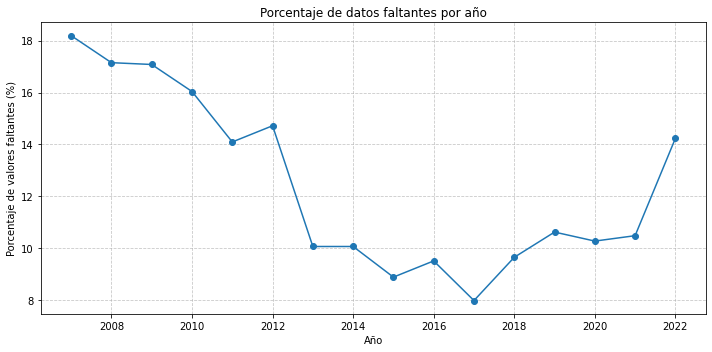

In [ ]:
# Asegurarse de que la columna 'year' esté en formato numérico
#Data_year_filtered['year'] = pd.to_numeric(Data_year_filtered['year'], errors='coerce')

# Agrupar por año y calcular el porcentaje de valores faltantes por fila
missing_by_year = (
    Data_year_filtered.groupby('year')
    .apply(lambda df: df.isna().sum().sum() / df.size * 100)
    .reset_index(name='Porcentaje_faltantes')
)

# Mostrar resultados ordenados
missing_by_year.sort_values(by='year', inplace=True)
print(missing_by_year)



plt.figure(figsize=(10, 5))
plt.plot(missing_by_year['year'], missing_by_year['Porcentaje_faltantes'], marker='o')
plt.title('Porcentaje de datos faltantes por año')
plt.xlabel('Año')
plt.ylabel('Porcentaje de valores faltantes (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Ahora, a partir del análisis exploratorio donde se identifico que hay paíeses recientemente se añadieron a la red, se elimanarán aquellos que lleven menos de  

Este código implementa un proceso de imputación de valores faltantes para variables numéricas en el conjunto de datos. Para ello se utiliza el promedio de la variable para el año, país y región en específico. En caso de que no haya datos suficientes se omite la fila vacía. Adicionalmente, antes de imputar el valor faltante, se extraen los valores anteriores y posteriores (si existen). Esto permite validar que el valor interpolado esté dentro de un rango razonable, por ejemplo, para evitar que el promedio regional del año actual sea muy superior al valor siguiente de ese mismo país.

In [36]:

# --- Imputación por promedio regional (sin verificación temporal) ---
imputed_total = 0
skipped_missing_mean = 0

for var in var_num:
    for idx, row in Data_year_filtered[Data_year_filtered[var].isna()].iterrows():
        region = row['region']
        year = row['year']
        country = row['countryCode']

        # Calcular promedio regional del año, sin el país actual
        regional_mean = (
            Data_year_filtered[
                (Data_year_filtered['region'] == region) &
                (Data_year_filtered['year'] == year) &
                (~Data_year_filtered[var].isna()) &
                (Data_year_filtered['countryCode'] != country)
            ][var].mean()
        )

        # Si no hay promedio regional, saltar
        if pd.isna(regional_mean):
            skipped_missing_mean += 1
            continue

        # Imputar el valor faltante con el promedio regional
        Data_year_filtered.at[idx, var] = regional_mean
        imputed_total += 1

# Mostrar resumen
print("Total de valores imputados:", imputed_total)
print("Saltados por falta de promedio regional:", skipped_missing_mean)




Total de valores imputados: 2186
Saltados por falta de promedio regional: 681


Imputación Multiple: Es un proceso en tres pasos:

- Imputación repetida: Se generan múltiples versiones del conjunto de datos, cada una con los valores faltantes completados de forma diferente, usando un modelo probabilístico.
Ejemplo: si faltan datos en una columna de ingresos, se imputan varios posibles valores realistas basados en otras variables (como edad, educación, etc.).
- Análisis por separado: Cada conjunto imputado se analiza por separado (por ejemplo, se entrena un modelo, se calcula una media, etc.).
- Combinación de resultados: Finalmente, los resultados de los distintos análisis se promedian o combinan estadísticamente, lo que captura la incertidumbre sobre los datos faltantes y genera estimaciones más robustas y confiables.

In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Cargar tus datos
data = Data.copy()

# Seleccionar solo las columnas numéricas (o convertir categóricas si es necesario)
numeric_data = data.select_dtypes(include='number')

# Crear imputador múltiple
imp = IterativeImputer(random_state=0, max_iter=10)

# Aplicar imputación
imputed_data = imp.fit_transform(numeric_data)

# Convertir a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=numeric_data.columns)

# Sustituir en tu dataset original si lo deseas
data[numeric_data.columns] = imputed_df


/Users/ricardoortiz/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"



- Investigar sobre series de tiempo de ArimaX (Revisar LSTM)
- Redes recurrentes. 
- Revisar SVM 

https://odin.opendatawatch.com/